In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


In [ ]:
! kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 73% 44.0M/60.3M [00:00<00:00, 142MB/s]
100% 60.3M/60.3M [00:00<00:00, 167MB/s]


In [ ]:
! kaggle datasets download -d apollo2506/facial-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/apollo2506/facial-recognition-dataset
License(s): CC0-1.0
 94% 56.0M/59.7M [00:00<00:00, 63.5MB/s]
100% 59.7M/59.7M [00:01<00:00, 60.7MB/s]


In [ ]:
fiel1_name = '/content/facial-recognition-dataset.zip'
file2_name = '/content/fer2013.zip'

In [ ]:
from zipfile import ZipFile

with ZipFile(fiel1_name,'r') as zip:
  zip.extractall()
  print('Done')

with ZipFile(file2_name,'r') as zip:
  zip.extractall()
  print('Done')

Done
Done


In [ ]:
! mkdir data

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, \
    f1_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2

from keras.src import layers, models, regularizers, optimizers
from keras.src.applications.vgg19 import VGG19
from keras.src.applications.vgg16 import VGG16
from keras.src.applications.resnet import ResNet50
from keras.src.applications.resnet import ResNet152

from keras.src.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.src.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.src.utils import plot_model
import shutil
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Input


In [ ]:
train_dir = '/content/data/Training'
test_dir = '/content/data/Testing'

def remove_checkpoints(dir_path):
    checkpoints_path = os.path.join(dir_path, '.ipynb_checkpoints')
    if os.path.exists(checkpoints_path):
        shutil.rmtree(checkpoints_path)

remove_checkpoints(train_dir)
remove_checkpoints(test_dir)

data_gen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=10,  # Less rotation
        width_shift_range=0.1,  # Less shift
        height_shift_range=0.1,  # Less shift
        zoom_range=0.1,  # Less zoom
        shear_range=0.1,  # Less shear
        horizontal_flip=True,
        validation_split=0.2,
        fill_mode='nearest',
    )

In [ ]:
def get_generators(target_size):
    train_gen = data_gen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=16,
        class_mode='categorical',
        subset='training',
        color_mode='grayscale'
    )
    val_gen = data_gen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=16,
        class_mode='categorical',
        subset='validation',
        color_mode='grayscale'
    )
    test_gen = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=16,
        class_mode='categorical',
        color_mode='grayscale'
    )
    return train_gen, val_gen, test_gen

In [ ]:
def count_images_in_directory(directory):
    class_counts = {}
    # Iterate over class directories and count images
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            # Count the number of files in each class directory
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [ ]:
def create_model(base_model, num_classes, input_shape, l2_reg=0.01, dropout_rate=0.5):
    # Create a new input layer with the grayscale input shape
    inputs = Input(shape=input_shape)

    # Add a Conv2D layer to convert grayscale input to 3-channel
    x = Conv2D(3, (3, 3), padding='same')(inputs)

    # Use the base model with this new input layer
    x = base_model(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_reg))(x)

    model = Model(inputs=inputs, outputs=predictions)
    return model

In [ ]:
# Define callbacks for early stopping and learning rate reduction
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

# Define a function to train, evaluate, and plot model metrics
def train_and_evaluate(model, train_gen, val_gen, test_gen, modelName, epochs=15):
    # Display the model summary
    model.summary()

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    # Plot training and validation accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model.name} - Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plot loss and validation loss
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{modelName} - Training and Validation Loss')
    plt.legend()
    plt.show()

    # Save the model
    model.save(f'{modelName}_model.keras')
    print("Model saved as:", f'{modelName}_model.keras')

    return history

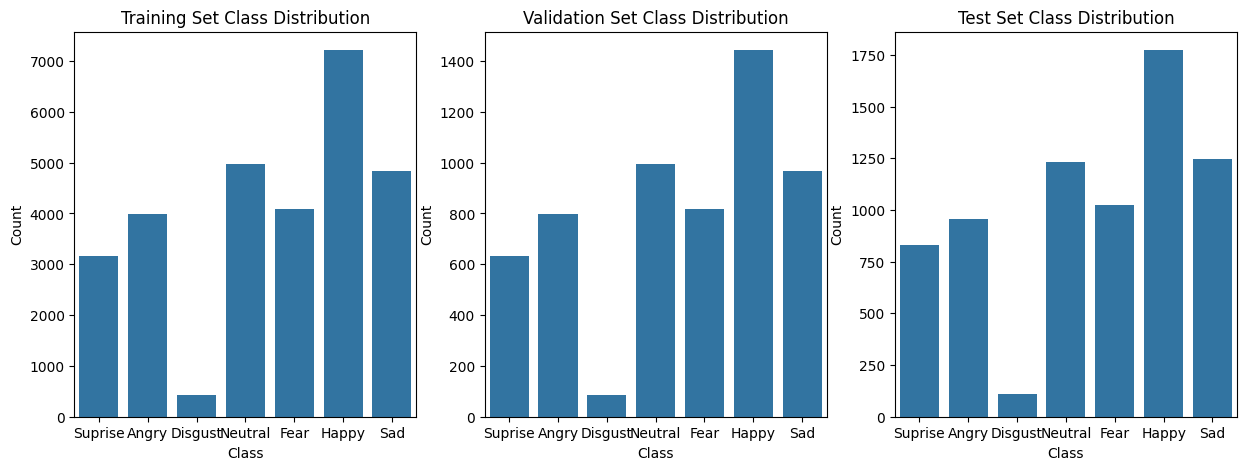

In [ ]:
train_class_counts = count_images_in_directory(train_dir)

# Calculate the validation set class counts based on the split
validation_split = 0.2
val_class_counts = {key: int(value * validation_split) for key, value in train_class_counts.items()}  # Proper multiplication

# Get test set class counts
test_class_counts = count_images_in_directory(test_dir)

# Plot class distribution for training, validation, and test datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(x=list(train_class_counts.keys()), y=list(train_class_counts.values()), ax=axes[0])
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

sns.barplot(x=list(val_class_counts.keys()), y=list(val_class_counts.values()), ax=axes[1])
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

sns.barplot(x=list(test_class_counts.keys()), y=list(test_class_counts.values()), ax=axes[2])
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Count')

plt.show()

# **VGG16 Model**

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 3)       30        
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                

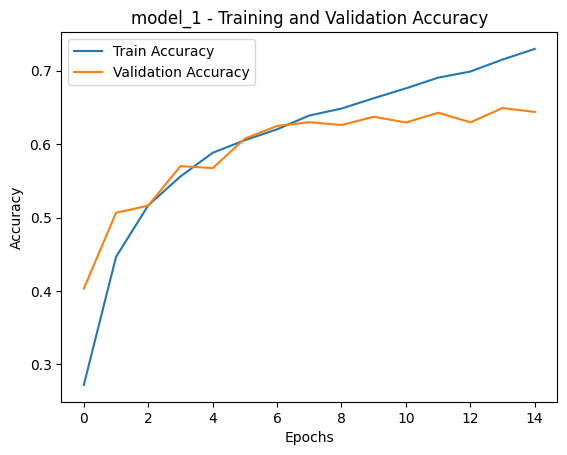

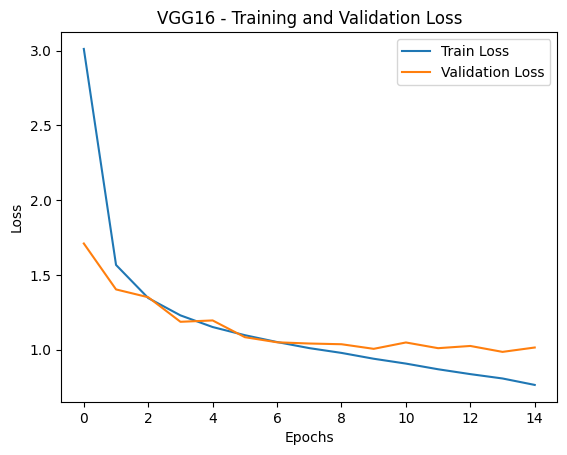

Model saved as: VGG16_model.keras


NameError: name 'test_loss' is not defined

In [ ]:
from keras.optimizers import Adam
from keras.applications import VGG16, VGG19, ResNet50, ResNet152, MobileNet

train_gen, val_gen, test_gen = get_generators((224, 224))

input_shape = (224, 224, 1)

# VGG16
VGG16_model = create_model(VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)), 7, input_shape, l2_reg=0.01, dropout_rate=0.5)
VGG16_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_VGG16 = train_and_evaluate(VGG16_model, train_gen, val_gen, test_gen, "VGG16")

[[6.0747891e-05 1.0639585e-06 4.5812165e-05 9.8866278e-01 9.8092677e-03
  7.1708666e-05 1.3486445e-03]]
[[3.3271397e-03 7.3216474e-06 1.1762663e-02 3.8219492e-03 9.2436332e-01
  5.5744682e-02 9.7286177e-04]]
[[4.4206265e-02 2.0353933e-04 6.1828908e-02 5.0236639e-03 4.0772006e-01
  4.7919092e-01 1.8266519e-03]]
[[2.6196094e-02 2.3303409e-04 7.5444177e-02 1.5068479e-03 2.0478533e-03
  2.3919705e-03 8.9217997e-01]]
[[9.8072159e-01 3.4856482e-04 1.8592315e-02 1.0359288e-05 5.1380293e-06
  2.8003723e-04 4.2079861e-05]]
[[4.0695950e-02 2.7557048e-03 2.9772061e-01 4.3654631e-04 2.4122477e-02
  6.3026130e-01 4.0073744e-03]]
[[4.0695950e-02 2.7557048e-03 2.9772061e-01 4.3654631e-04 2.4122477e-02
  6.3026130e-01 4.0073744e-03]]
[[4.4206265e-02 2.0353933e-04 6.1828908e-02 5.0236639e-03 4.0772006e-01
  4.7919092e-01 1.8266519e-03]]
[[6.0747891e-05 1.0639585e-06 4.5812165e-05 9.8866278e-01 9.8092677e-03
  7.1708666e-05 1.3486445e-03]]
[[3.3271397e-03 7.3216474e-06 1.1762663e-02 3.8219492e-03 9.2436

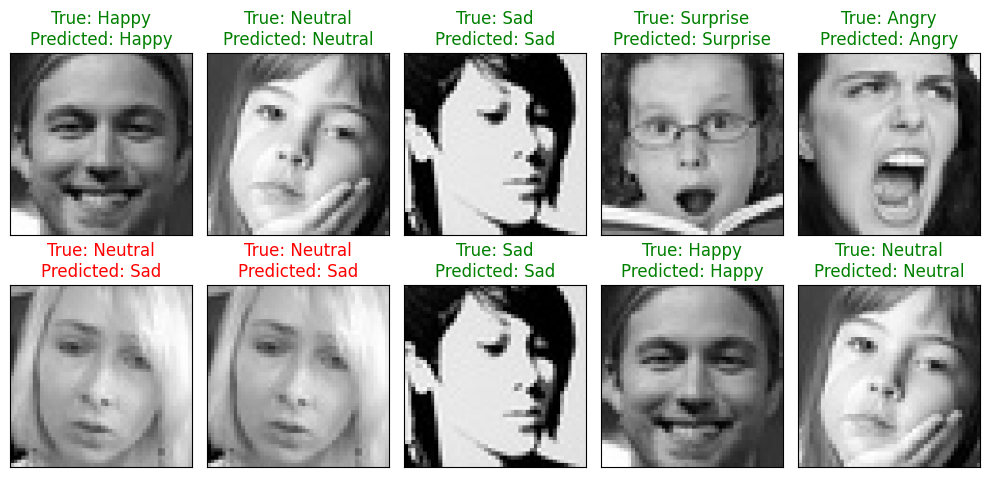

In [ ]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the saved MobileNet model
mobilenet_model = load_model("VGG16_model.keras")

# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_gen and model are already defined
batch_size = test_gen.batch_size

# Setting the random seed
np.random.seed()

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_gen) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_gen[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_gen[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(mobilenet_model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]
    print(mobilenet_model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0))

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on the test set and calculate additional metrics
test_loss, test_acc = VGG16_model.evaluate(test_gen)
# Get predictions and ground truth labels from the test set
predictions = VGG16_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)  # Get class with highest probability
true_classes = test_gen.classes

# Calculate precision, recall, and F1-score
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')
f1 = f1_score(true_classes, predicted_classes, average='macro')

# Print precision, recall, and F1 score
print("Accuracy: ", test_acc)
print("Loss: ", test_loss)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

449/449 [==============================] - 29s 65ms/step
Accuracy:  0.6453050971031189
Loss:  1.029948115348816
Precision: 0.14263797426758212
Recall: 0.14418310728552836
F1 Score: 0.14023423141692598
